### 4-1. 상추 가격예측을 통한 LSTM 모델 생성
- 입력데이터의 형식 및 출력데이터의 형식이 동일하여, 하나의 채소에 LSTM을 최적화 한 뒤 다른 채소에 적용.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def get_climate_data(vege) :
    dome = False
    fore = False
    if f'{vege}_na.csv' in os.listdir('./data/climate_final/국내') :
        climate_domestic = pd.read_csv(f'./data/climate_final/{vege}_na.csv',
                                             index_col = 0,
                                             parse_dates = True,
                                             encoding = 'cp949')
        dome = True
    if f'{vege}_for.csv' in os.listdir('./data/climate_final/해외') :
        climate_foreign = pd.read_csv(f'./data/climate_final/해외/{vege}_for.csv',
                                         index_col = 0,
                                         parse_dates = True,
                                         encoding = 'cp949')
        fore = True
    if dome and fore :
        merged_climate = pd.merge(climate_foreign, climate_domestic, left_index = True, right_index = True)
        return merged_climate.loc['2011':]
    elif dome :
        return climate_domestic.loc['2011':]
    else :
        return climate_foreign.loc['2011':]

In [3]:
def get_price_data(vege, anually = False, rank = '중품'):
    if vege == '마늘' :
        vege = '피' + vege
    elif vege == '고추':
        vege = '풋' + vege
    prices = pd.read_csv('./data/vegetable_price.csv',
                               index_col = 1,
                               parse_dates = True,
                               encoding = 'cp949')
    price_columns = ['Name', 'SubCategory', 'Rank', 'Category', 'Price']
    prices.drop(['Unnamed: 0'], axis = 1, inplace = True)
    prices.columns = price_columns
    prices = prices.sort_values('0')
    if anually :
        df = prices[(prices.Name == vege) & (prices.Category == '평년') & (prices.Rank == rank)]
        return df['2011':]
    else :
        df = prices[(prices.Name == vege) & (prices.Category == '전국평균') & (prices.Rank == rank)]
        return df['2011':]

In [4]:
null_breaker = {
#     '시금치' : ['Ap', 'Freeze']
}

In [5]:
vege_name = '상추'

In [6]:
climate_df = get_climate_data(vege_name)
price_df = get_price_data(vege_name)

if vege_name in null_breaker.keys():
    dead_column = []
    for column in climate_df.columns :

        for eliminate in null_breaker[vege_name] :
            if eliminate in column :
                dead_column.append(column)

    climate_df.drop(dead_column, axis = 1, inplace = True)

In [7]:
climate_df['month'] = climate_df.index.month

In [8]:
price_df = price_df[price_df.SubCategory == '적상추']

In [9]:
price_df

,Name,SubCategory,Rank,Category,Price
0,,,,,
2011-01-03,상추,적상추,중품,전국평균,8000
2011-01-04,상추,적상추,중품,전국평균,8000
2011-01-05,상추,적상추,중품,전국평균,8000
2011-01-06,상추,적상추,중품,전국평균,6000
2011-01-07,상추,적상추,중품,전국평균,8000
...,...,...,...,...,...
2021-10-08,상추,적상추,중품,전국평균,32600
2021-10-12,상추,적상추,중품,전국평균,28000
2021-10-13,상추,적상추,중품,전국평균,31000


In [10]:
merged_df = pd.concat([climate_df.loc[price_df.index[0] : price_df.index[-1]], price_df.Price], axis = 1)
merged_df.ffill(inplace = True)

In [11]:
merged_df

,m_Temp_114,m_Rainfall_114,m_WindSpeed_114,m_Humidity_114,m_SteamPressure_114,m_LandAp_114,m_SeaAp_114,m_Sunshine_114,m_Snow_114,m_LandTemp_114,...,a_LandAp_236,a_SeaAp_236,a_Sunshine_236,a_Snow_236,a_LandTemp_236,TempMin_236,TempMax_236,Freeze_236,month,Price
2011-01-03,-8.758333,0.0,0.9,74.250000,2.350000,1005.900000,1025.600000,0.625,0.0,-6.658333,...,1020.950000,1022.350000,0.442857,0.0,0.066667,-11.9,1.2,0,1,8000.0
2011-01-04,-6.091667,0.0,1.3,74.750000,2.908333,1003.333333,1022.783333,0.525,0.0,-5.025000,...,1021.025000,1022.425000,0.057143,0.0,0.133333,-10.4,0.3,0,1,8000.0
2011-01-05,-1.775000,0.1,2.2,67.000000,3.616667,1001.883333,1020.975000,0.000,0.2,-1.450000,...,1020.958333,1022.358333,0.185714,0.0,0.158333,-1.1,2.4,0,1,8000.0
2011-01-06,-8.091667,0.0,2.2,67.250000,2.250000,1005.191667,1024.833333,0.525,0.0,-7.100000,...,1025.825000,1027.225000,0.800000,0.0,-0.075000,-3.9,-0.4,0,1,6000.0
2011-01-07,-12.108333,0.0,1.6,70.166667,1.683333,1010.050000,1030.100000,0.675,0.0,-9.416667,...,1027.258333,1028.675000,0.828571,0.0,-0.258333,-12.5,0.6,0,1,8000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,14.700000,3.2,1.2,85.750000,14.258333,1002.941667,1020.783333,0.140,0.0,18.250000,...,1020.175000,1021.775000,0.025000,0.0,19.841667,12.6,17.5,0,10,32600.0
2021-10-12,17.008333,0.0,1.2,70.250000,13.525000,1006.533333,1024.250000,0.000,0.0,17.775000,...,1024.091667,1025.691667,0.000000,0.0,18.391667,15.7,17.0,0,10,28000.0
2021-10-13,15.333333,0.0,1.5,78.833333,13.508333,1008.308333,1026.175000,0.720,0.0,17.300000,...,1021.683333,1023.266667,0.485714,0.0,23.550000,16.0,24.3,0,10,31000.0
2021-10-14,16.825000,0.0,2.5,82.666667,15.733333,1004.008333,1021.716667,0.480,0.0,18.333333,...,1018.025000,1019.575000,0.828571,0.0,23.566667,14.2,25.7,0,10,33300.0


In [12]:
df = merged_df
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [13]:
df

array([[-1.77524181, -0.24053222, -0.97652114, ...,  0.        ,
        -1.59062473, -0.72459667],
       [-1.52863156, -0.24053222, -0.56219323, ...,  0.        ,
        -1.59062473, -0.72459667],
       [-1.12943122, -0.20669933,  0.37004458, ...,  0.        ,
        -1.59062473, -0.72459667],
       ...,
       [ 0.45272765, -0.24053222, -0.35502927, ...,  0.        ,
         1.04377084,  1.05158728],
       [ 0.59067526, -0.24053222,  0.68079052, ...,  0.        ,
         1.04377084,  1.22920568],
       [ 0.58836329, -0.24053222, -1.80517697, ...,  0.        ,
         1.04377084,  1.53810723]])

WINDOWS_NUM을 2 ~ 20 사이의 값을 넣어봄.

In [14]:
WINDOWS_NUM = 2
DAY_AFTER = 0
X = []
y = []
for i in range(len(df) - WINDOWS_NUM - DAY_AFTER ):
    X.append([df[i + j] for j in range(WINDOWS_NUM)])
    y.append(merged_df.Price[i + DAY_AFTER +  WINDOWS_NUM])

In [15]:
X = np.array(X)
y = np.array(y)

In [16]:
X.shape, y.shape

((3937, 2, 94), (3937,))

In [17]:
X_train = X[:3000]
y_train = y[:3000]
X_test = X[3000:]
y_test = y[3000:]

In [18]:
model = Sequential()
model.add(LSTM(128, activation = 'LeakyReLU', input_shape = (WINDOWS_NUM, 94)))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               114176    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 114,305
Trainable params: 114,305
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='mse', optimizer='adam', metrics = 'mse')

In [21]:
mc = ModelCheckpoint(f'lettuce_{WINDOWS_NUM}.h5', monitor='val_loss', mode='min', save_best_only=True)

In [22]:
model.fit(X_train, y_train, validation_split = 0.2, epochs = 20, batch_size = 5, callbacks = [mc])

Epoch 1/20
480/480 [==============================] - 3s 5ms/step - loss: 241434080.0000 - mse: 241434080.0000 - val_loss: 194464544.0000 - val_mse: 194464544.0000
Epoch 2/20
480/480 [==============================] - 2s 4ms/step - loss: 117102416.0000 - mse: 117102416.0000 - val_loss: 169534112.0000 - val_mse: 169534112.0000
Epoch 3/20
480/480 [==============================] - 2s 4ms/step - loss: 104089656.0000 - mse: 104089656.0000 - val_loss: 151928064.0000 - val_mse: 151928064.0000
Epoch 4/20
480/480 [==============================] - 2s 4ms/step - loss: 92242736.0000 - mse: 92242736.0000 - val_loss: 139429168.0000 - val_mse: 139429168.0000
Epoch 5/20
480/480 [==============================] - 2s 4ms/step - loss: 79966936.0000 - mse: 79966936.0000 - val_loss: 119049568.0000 - val_mse: 119049568.0000
Epoch 6/20
480/480 [==============================] - 2s 4ms/step - loss: 66991372.0000 - mse: 66991372.0000 - val_loss: 101667296.0000 - val_mse: 101667280.0000
Epoch 7/20
480/480 [==

val_loss의 값이 가장 작은 모델을 확인

In [24]:
from tensorflow.keras.models import load_model

In [25]:
model2 = load_model(f'lettuce_{WINDOWS_NUM}.h5')
train_preds = model2.predict(X_train)
test_preds = model2.predict(X_test)

In [540]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

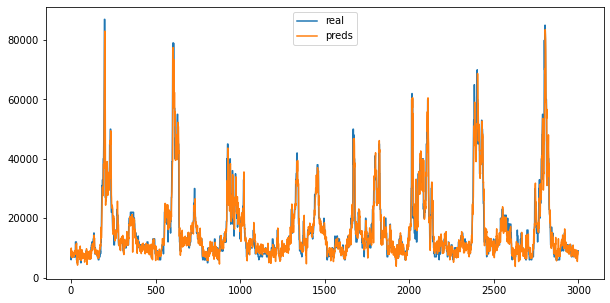

In [26]:
plt.figure(figsize = (10, 5))
plt.plot(y_train, label = 'real')
plt.plot(train_preds, label = 'preds')
plt.legend()
plt.show()

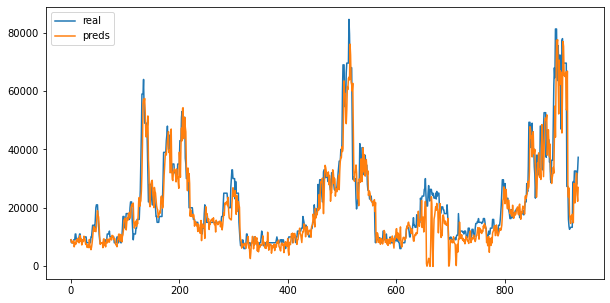

In [27]:
plt.figure(figsize = (10, 5))
plt.plot(y_test, label = 'real')
plt.plot(test_preds, label = 'preds')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
print('explained_variance_score:', explained_variance_score(y_test, test_preds))
print('mean_squared_error:', mean_squared_error(y_test, test_preds))
print('r2_score:', r2_score(y_test, test_preds))

explained_variance_score: 0.8342686985201859
mean_squared_error: 40945241.27664468
r2_score: 0.8221733803666693
